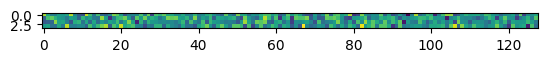

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision

img = np.random.randn(4,128,1)

plt.imshow(img)


In [ ]:
import torch

In [ ]:
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.CenterCrop((64,64))
    ])

def apply_transform(example):
  example["image"] = example["image"].type(torch.float)
  example["image"] = transform(example["image"])




  return example

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 10.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
from datasets import load_dataset


train = load_dataset("keremberke/chest-xray-classification", "mini", split = "train")
train = train.with_format("torch")
train = train.map(apply_transform)
batch_size = 16
train_loader = DataLoader(train, batch_size = batch_size, shuffle = True)

classes = ('NORMAL', 'PNEUMONIA')


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

chest-xray-classification.py:   0%|          | 0.00/3.89k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/158k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/4 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/4 [00:00<?, ? examples/s]

Map:   0%|          | 0/4 [00:00<?, ? examples/s]

NORMAL
torch.Size([3, 64, 64])


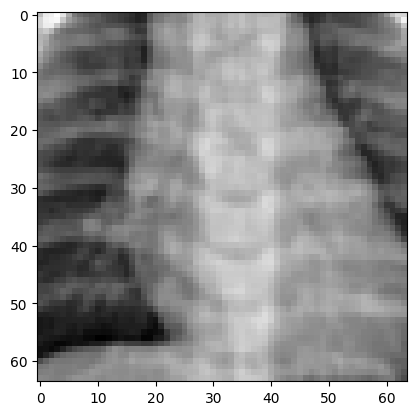

In [ ]:
iter_train = iter(train_loader)

batch = next(iter_train)

image, label = batch["image"][0], batch["labels"][0]


print(classes[label])
print(image.shape)

np_img = image.numpy()
np_img = (np_img-np.min(np_img))/(np.max(np_img)-np.min(np_img)) # Normalizes range to [0..1]
np_img = np.transpose(np_img, (1,2,0))
plt.imshow(np_img)




In [ ]:
latent_dim = 128

import torch.nn as nn
import torch.nn.functional as F

class Generator(nn.Module):
  #goal: try and convert the image so that it outputs in the size of a [3,64,64] image
  def __init__(self):
    super(Generator, self).__init__()
    self.model = nn.Sequential(
      nn.Linear(in_features = latent_dim, out_features = 6*6*64),
      nn.ReLU(),
      nn.BatchNorm1d(6*6*64),

      nn.Unflatten(dim = 1, unflattened_size = (64,6,6)),



      # 1st Block
      nn.ConvTranspose2d(in_channels = 64, out_channels = 32, kernel_size = 3, padding=1),
      nn.ReLU(),
      nn.BatchNorm2d(32),


    )
  def forward (self, x):
    img = self.model(x)

    return img


In [ ]:
G = Generator().to('cpu')


In [ ]:
z = torch.zeros([2304,128])
output = G(z)

print(output.shape)

torch.Size([2304, 32, 6, 6])
